In [ ]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
#
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
#
# pip install

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas.plotting as pd_plt
import matplotlib.colors as plt_colors
from IPython.display import display, display_html
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold,StratifiedShuffleSplit, StratifiedKFold, validation_curve, cross_validate, FixedThresholdClassifier, TunedThresholdClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import warnings

In [3]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

*В качестве метрики выбираем roc_auc, потому что нам ложноположительные и ложноотрицательные результаты одинаково важны (отметить качественным некачественное вино и наоборот - одинаково неприемлемо). Более того, критерий roc_auc устойчив к несбалансированным классам*

*Таким образом, будет в качестве целевой метрики использовать её*

In [4]:
main_score = 'roc_auc'

In [5]:
warnings.filterwarnings("ignore")

## Загружаем данные

In [6]:
path_train = path_train
train = pd.read_csv(path_train)

## EDA анализ

In [7]:
display(train.describe())
train.info()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1294.000000,1294.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1294.000000,1293.000000,1295.000000,1295.000000
mean,8.438872,0.500920,0.298880,2.573398,0.085467,15.362934,44.651351,0.996576,3.303648,0.678415,10.676100,5.937452
std,1.818823,0.182181,0.200443,1.366700,0.045056,10.487662,35.420622,0.001968,0.157238,0.169927,1.174136,0.955717
min,4.700000,0.120000,0.000000,0.900000,0.012000,1.000000,7.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.200000,0.360000,0.120000,1.900000,0.068000,7.000000,20.000000,0.995315,3.200000,0.570000,9.600000,5.000000
50%,8.100000,0.480000,0.310000,2.200000,0.078000,13.000000,34.000000,0.996600,3.300000,0.640000,10.500000,6.000000
75%,9.400000,0.620000,0.455000,2.600000,0.090000,21.000000,57.000000,0.997765,3.390000,0.760000,11.500000,7.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003200,4.010000,2.000000,14.900000,8.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1294 non-null   float64
 1   volatile acidity      1294 non-null   float64
 2   citric acid           1295 non-null   float64
 3   residual sugar        1295 non-null   float64
 4   chlorides             1295 non-null   float64
 5   free sulfur dioxide   1295 non-null   float64
 6   total sulfur dioxide  1295 non-null   float64
 7   density               1295 non-null   float64
 8   pH                    1294 non-null   float64
 9   sulphates             1293 non-null   float64
 10  alcohol               1295 non-null   float64
 11  quality               1295 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 121.5 KB


*Согласно info некоторые столбцы содержат пропуски*

In [8]:
train[train.isna().any(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
637,6.4,0.530,0.09,3.9,0.123,14.0,31.0,0.99680,3.50,NaN,11.0,4
698,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
720,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5
1146,7.2,NaN,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6


*Таких строк (с пропусками) оказалось немного, поэтому просто дропнем их*

In [9]:
train.dropna(inplace=True)

*Теперь расммотрим вопрос наличия дубликатов в данных*

In [10]:
train.duplicated().sum()

276

*Кажется, это и есть свинья. Смело удаляем дубликаты*

In [11]:
train.drop_duplicates(inplace=True)

*Глянем че там как распределены значениях в столбцах*

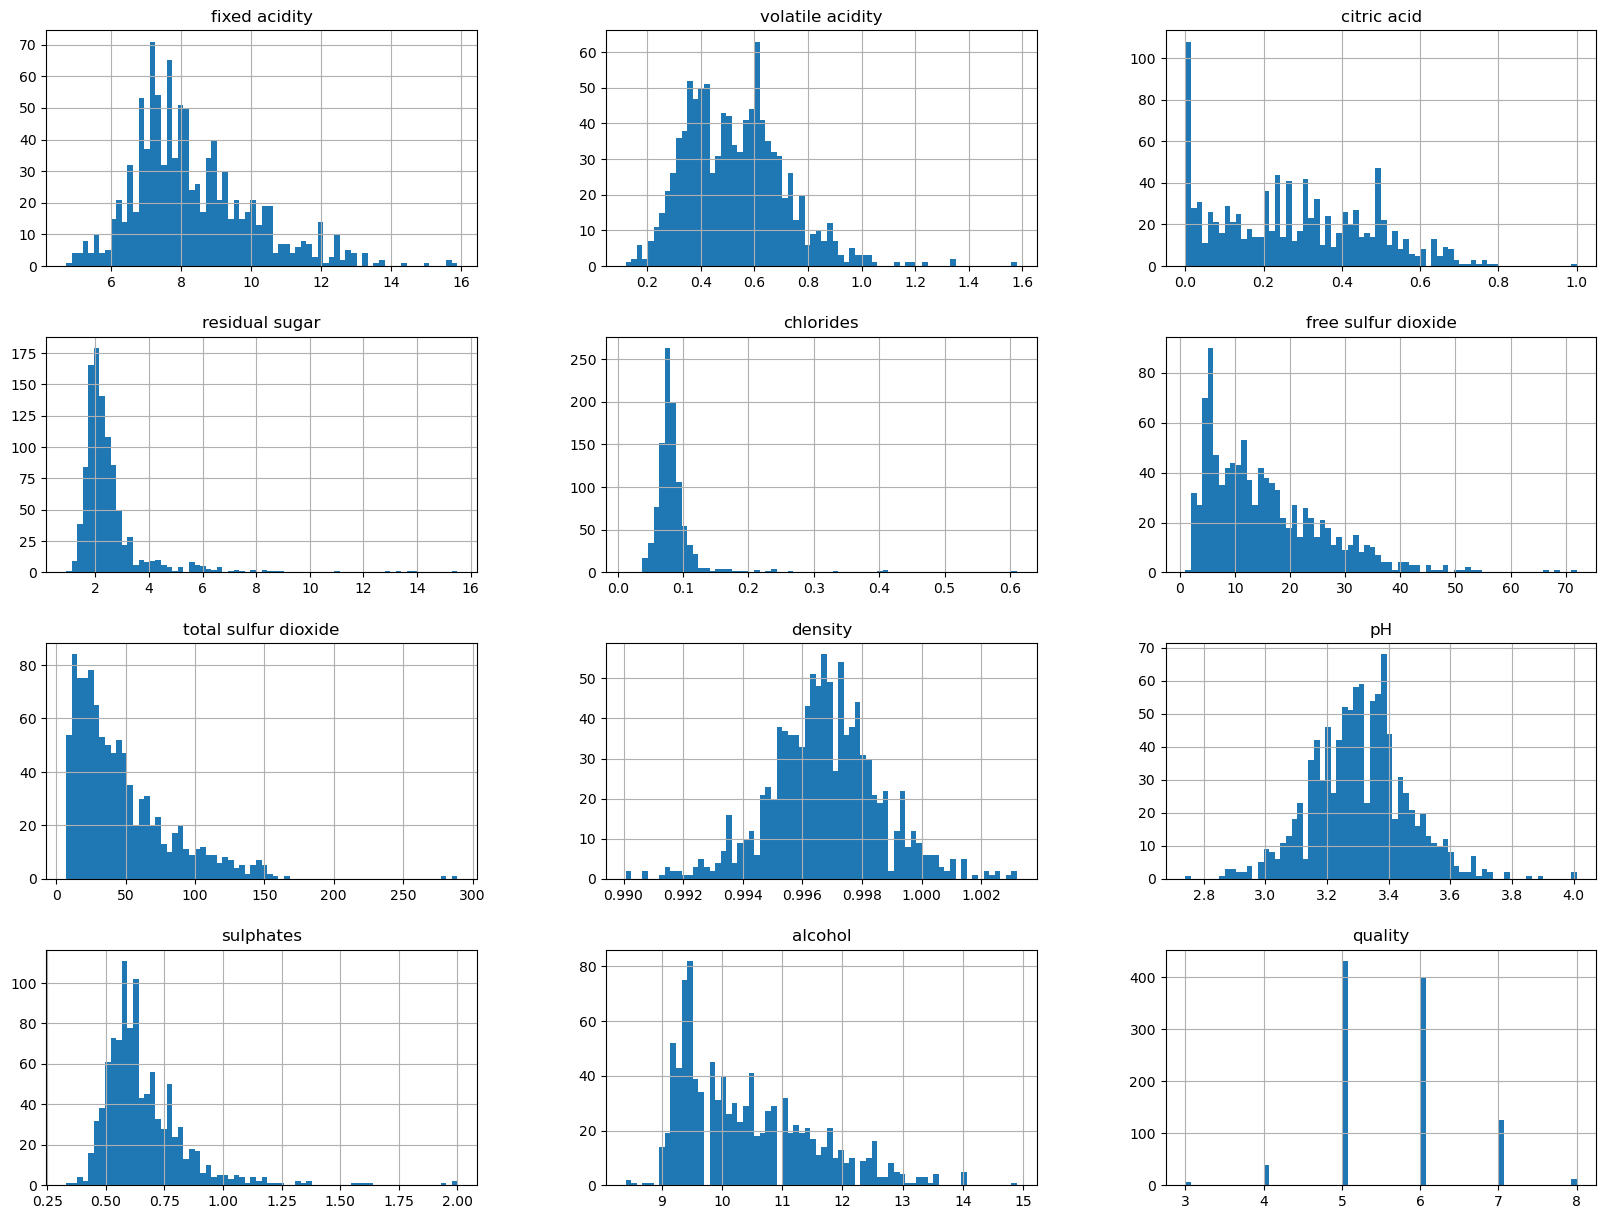

In [12]:
train.hist(bins = 70, figsize = (20,15))
plt.show()

## Сплитуем тренировочный и тестовый наборы

In [13]:
X = train.drop('quality', axis=1)
y = train['quality']

X_train,X_test,y_train,y_test = train_test_split(X, y, stratify=y)

*Заметим ('quality' в describe), что качество алкоголя меняется от 3 до 8. Так как нам важно определять именно качественный алкоголь (7 и 8), то переобозначим такой исход как 1, остальные - как 0. Таким образом осуществлён переход от мультиклассовой классификации к бинарной*

In [14]:
y_train = y_train.apply(lambda x: 0 if x < 7 else 1)
y_test = y_test.apply(lambda x: 0 if x < 7 else 1)

## Метод ближайших соседей

In [15]:
cv = StratifiedShuffleSplit(test_size = 0.25, n_splits = 10)

In [54]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier', KNeighborsClassifier())])

n_neighbors=np.arange(50,100,4)
p=[1,2,3]
weights=['uniform','distance']

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
     'classifier': [KNeighborsClassifier(n_jobs=-1)],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p,
     'classifier__weights': weights
     }
]

grid_KNN = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring=main_score)
grid_KNN.fit(X_train,y_train)

grid_result_KNN = pd.DataFrame(grid_KNN.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_KNN

,94,4,58,166,184,76,40,112,130,148,...,194,212,68,140,176,158,230,50,32,14
mean_fit_time,0.015271,0.014021,0.022331,0.012655,0.012342,0.019767,0.011341,0.017128,0.014944,0.010423,...,0.013157,0.009289,0.015234,0.014309,0.012747,0.012272,0.013746,0.012503,0.014752,0.025283
std_fit_time,0.005415,0.003445,0.009059,0.002309,0.002284,0.008994,0.003929,0.007127,0.00993,0.00542,...,0.001676,0.004096,0.003377,0.001978,0.002905,0.005831,0.001832,0.001638,0.00551,0.021846
mean_score_time,0.071893,0.041255,0.058,0.068333,0.106861,0.061758,0.055354,0.066869,0.099086,0.061688,...,0.319111,0.278114,0.258566,0.348249,0.334639,0.280845,0.33029,0.334075,0.348869,0.222349
std_score_time,0.013217,0.006597,0.007514,0.011548,0.017471,0.010056,0.011427,0.016418,0.028387,0.010999,...,0.10245,0.015291,0.075668,0.078014,0.029113,0.069581,0.081092,0.073942,0.090575,0.057411
param_classifier,KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),...,KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1),KNeighborsClassifier(n_jobs=-1)
param_classifier__n_neighbors,70,50,62,86,90,66,58,74,78,82,...,90,94,62,78,86,82,98,58,54,50
param_classifier__p,1,1,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,3,3,3
param_classifier__weights,distance,distance,distance,distance,distance,distance,distance,distance,distance,distance,...,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform,uniform
param_preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler()
params,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...,{'classifier': KNeighborsClassifier(n_jobs=-1)...


In [17]:
grid_KNN.best_params_

{'classifier': KNeighborsClassifier(n_jobs=-1),
 'classifier__n_neighbors': 78,
 'classifier__p': 1,
 'classifier__weights': 'distance',
 'preprocessing': StandardScaler()}

<Axes: >

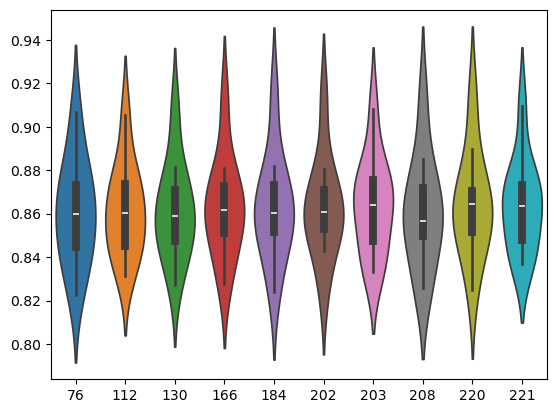

In [18]:
mask = grid_result_KNN.index[grid_result_KNN.index.str.endswith("_test_score")][:-3]
tabl = grid_result_KNN.loc[mask].iloc[:,:10]
sns.violinplot(data=tabl)

## Логистическая регрессия

In [19]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression(max_iter=10000))])

scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear', 'sag', 'saga']},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear']},
    {'preprocessing': scaling,'clf__penalty': [None], 
         'clf__solver': ['lbfgs','newton-cg']}
    ]


grid_LR = GridSearchCV(pipe, param_grid, cv = cv, return_train_score = True, scoring=main_score)
grid_LR.fit(X_train, y_train)

grid_result_LR = pd.DataFrame(grid_LR.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_LR

,22,21,2,14,18,6,9,17,13,1,...,20,31,8,27,7,3,15,19,11,23
mean_fit_time,0.007578,0.00534,0.015579,0.030605,0.045243,0.012684,0.005648,0.018521,0.009479,0.007242,...,0.009729,0.023206,0.004012,0.020979,0.006141,0.010382,0.010468,0.008716,0.009378,0.007858
std_fit_time,0.008349,0.007001,0.005992,0.007677,0.00898,0.005255,0.006806,0.006535,0.007745,0.006653,...,0.008008,0.007811,0.00606,0.007049,0.007527,0.007435,0.007029,0.007369,0.007657,0.007657
mean_score_time,0.002207,0.003126,0.006028,0.006851,0.002974,0.005583,0.001563,0.000351,0.003827,0.005901,...,0.004428,0.002914,0.003737,0.002454,0.007504,0.004677,0.00524,0.005328,0.0,0.003127
std_score_time,0.004652,0.006252,0.006517,0.007373,0.005284,0.006542,0.004688,0.001053,0.006256,0.007719,...,0.006797,0.00528,0.006063,0.004775,0.007332,0.007145,0.006991,0.006922,0.0,0.006253
param_clf__penalty,l1,l1,l2,l2,l2,l2,l2,l2,l2,l2,...,l1,None,l2,None,l2,l2,l2,l2,l2,l1
param_clf__solver,liblinear,liblinear,newton-cg,sag,saga,lbfgs,liblinear,saga,sag,newton-cg,...,liblinear,newton-cg,liblinear,lbfgs,lbfgs,newton-cg,sag,saga,liblinear,liblinear
param_preprocessing,RobustScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,MinMaxScaler(),Normalizer(),MinMaxScaler(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
params,"{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...",...,"{'clf__penalty': 'l1', 'clf__solver': 'libline...","{'clf__penalty': None, 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': None, 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'lbfgs',...","{'clf__penalty': 'l2', 'clf__solver': 'newton-...","{'clf__penalty': 'l2', 'clf__solver': 'sag', '...","{'clf__penalty': 'l2', 'clf__solver': 'saga', ...","{'clf__penalty': 'l2', 'clf__solver': 'libline...","{'clf__penalty': 'l1', 'clf__solver': 'libline..."
split0_test_score,0.870862,0.871329,0.868998,0.868998,0.868998,0.868998,0.869697,0.868998,0.868765,0.868531,...,0.858741,0.862005,0.867366,0.847552,0.705128,0.705128,0.705128,0.705128,0.703263,0.701166
split1_test_score,0.87366,0.875758,0.874592,0.874825,0.874825,0.874359,0.875291,0.875758,0.875758,0.875758,...,0.870862,0.868998,0.87366,0.861538,0.675291,0.675758,0.675758,0.675758,0.673893,0.665501


In [20]:
grid_LR.best_params_

{'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'preprocessing': RobustScaler()}

<Axes: >

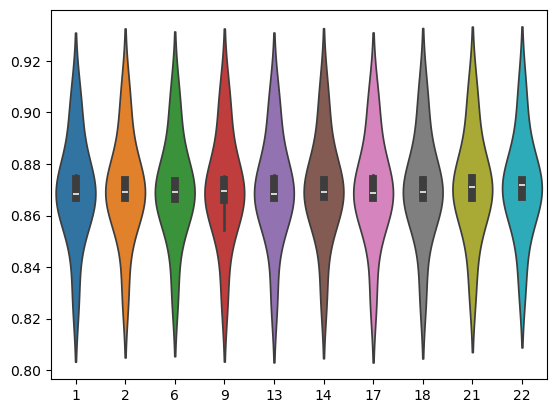

In [21]:
mask = grid_result_LR.index[grid_result_LR.index.str.endswith("_test_score")][:-3]
tabl = grid_result_LR.loc[mask].iloc[:,:10]
sns.violinplot(data=tabl)

*Получили в качестве параметра penalty - l2, поэтому для подбора параметра регуляризации целесообразно рассмотреть Validation Curve*

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])


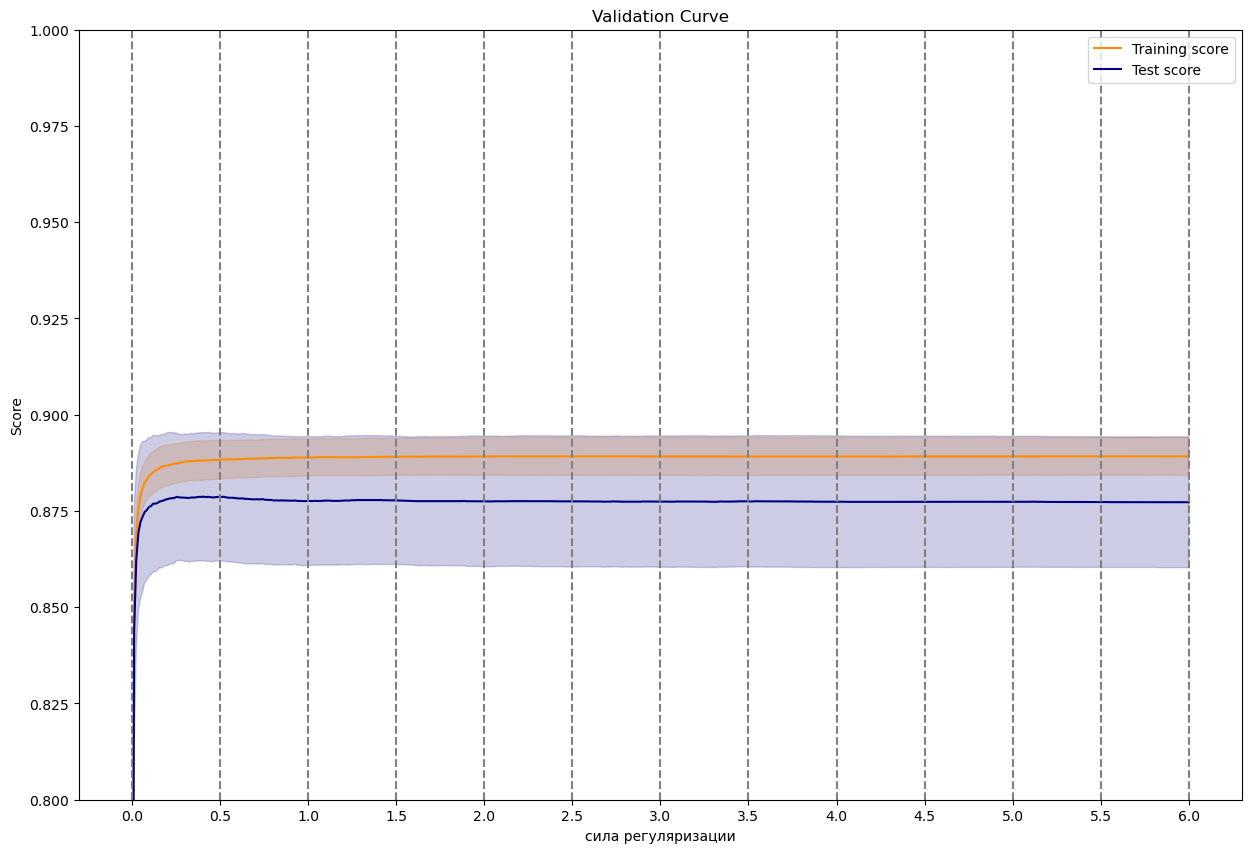

In [23]:
pipe_fin = make_pipeline(RobustScaler(), LogisticRegression(solver = 'liblinear', penalty = 'l2'))
print(pipe_fin)

n_range = np.linspace(0.0001, 6, 500)
train_scores, test_scores = validation_curve(
    pipe_fin , X_train, y_train,
    param_name = "logisticregression__C", 
    param_range = n_range,
    cv = cv, 
    scoring=main_score, 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15,10))

plt.title("Validation Curve")
plt.xlabel("сила регуляризации")
plt.ylabel("Score")
plt.ylim(0.8, 1)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label="Test score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
plt.xticks(np.linspace(0, 6, 13))
for i in np.arange(0,6.5,0.5):
    plt.vlines(i, 0.8, 1, linestyles='dashed', colors='gray')

plt.legend(loc="best")
plt.show();

## Наивный Байес

In [24]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           GaussianNB())])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling, 
     'clf': [GaussianNB()]}
    ]

grid_NB = GridSearchCV(pipe, param_grid, cv = cv, scoring=main_score)
grid_NB.fit(X_train, y_train)

grid_result_NB = pd.DataFrame(grid_NB.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result_NB

,0,1,2,3
mean_fit_time,0.010006,0.003127,0.006332,0.006727
std_fit_time,0.005214,0.006253,0.007756,0.006037
mean_score_time,0.003608,0.003204,0.006253,0.004274
std_score_time,0.002618,0.003925,0.007658,0.004248
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': GaussianNB(), 'preprocessing': Normali..."
split0_test_score,0.877706,0.877706,0.877706,0.763348
split1_test_score,0.801894,0.801894,0.801894,0.646212
split2_test_score,0.874591,0.874591,0.874591,0.725191


<Axes: >

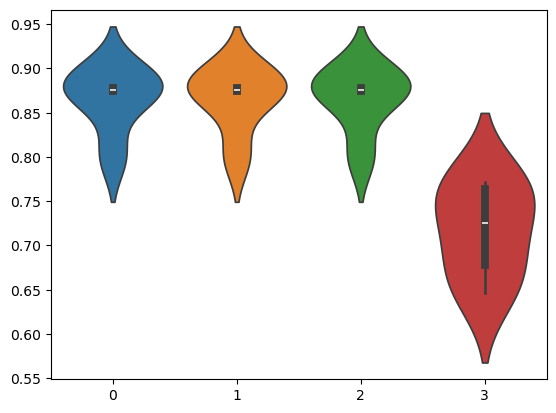

In [25]:
mask = grid_result_NB.index[grid_result_NB.index.str.endswith("_test_score")][:-3]
tabl = grid_result_NB.loc[mask].iloc[:,:10]
sns.violinplot(data=tabl)

## Сравнение моделей

In [26]:
model_NB = make_pipeline(grid_NB.best_params_['preprocessing'],GaussianNB())
model_LR = make_pipeline(grid_LR.best_params_['preprocessing'], LogisticRegression(solver = grid_LR.best_params_['clf__solver'],
                                                         penalty = grid_LR.best_params_['clf__penalty'], C=2))
model_KNN = make_pipeline(grid_KNN.best_params_['preprocessing'], KNeighborsClassifier(n_neighbors = grid_KNN.best_params_['classifier__n_neighbors'],
                                                                 p = grid_KNN.best_params_['classifier__p'],
                                                                 weights = grid_KNN.best_params_['classifier__weights']))

model_NB.fit(X_train,y_train)
model_LR.fit(X_train,y_train)
model_KNN.fit(X_train,y_train)

y_NB_pred = model_NB.predict(X_test)
y_LR_pred = model_LR.predict(X_test)
y_KNN_pred = model_KNN.predict(X_test)

print('GaussianNB')
print(classification_report(y_test, y_NB_pred))
print('LogisticRegression')
print(classification_report(y_test, y_LR_pred))
print('KNN')
print(classification_report(y_test, y_KNN_pred))

GaussianNB
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       220
           1       0.47      0.76      0.58        34

    accuracy                           0.85       254
   macro avg       0.72      0.82      0.75       254
weighted avg       0.89      0.85      0.87       254

LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       220
           1       0.70      0.41      0.52        34

    accuracy                           0.90       254
   macro avg       0.81      0.69      0.73       254
weighted avg       0.89      0.90      0.89       254

KNN
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       220
           1       1.00      0.06      0.11        34

    accuracy                           0.87       254
   macro avg       0.94      0.53      0.52       254
weighted avg       0.89      0.87      0

### ROC AUC и PR AUC

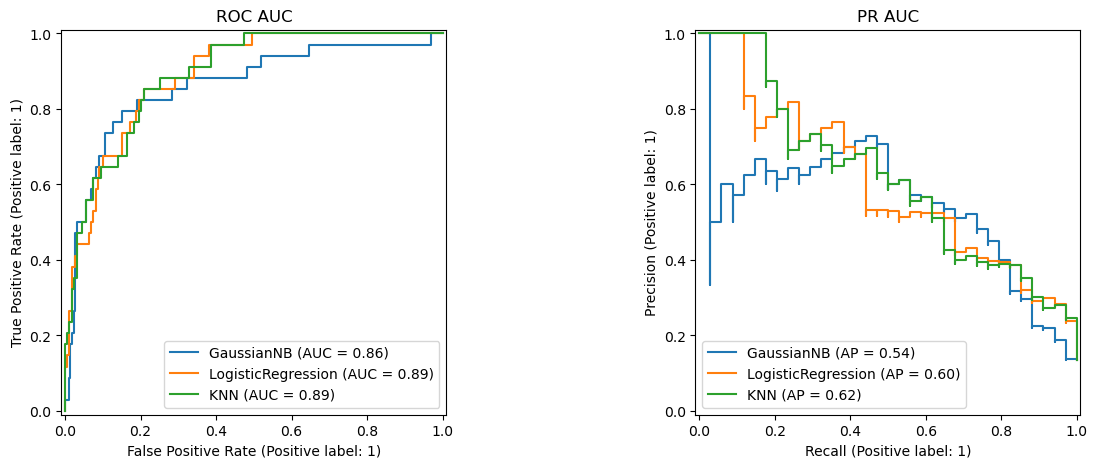

In [27]:
fig, [ax_roc, ax_pr] = plt.subplots(1,2, figsize=(15, 5))

ax_roc.set_title('ROC AUC')
RocCurveDisplay.from_estimator(model_NB, X_test, y_test, ax = ax_roc, name = 'GaussianNB');
RocCurveDisplay.from_estimator(model_LR, X_test, y_test, ax = ax_roc, name = 'LogisticRegression');
RocCurveDisplay.from_estimator(model_KNN, X_test, y_test, ax = ax_roc, name = 'KNN');

ax_pr.set_title('PR AUC')
PrecisionRecallDisplay.from_estimator(model_NB, X_test, y_test, ax = ax_pr, name = 'GaussianNB');
PrecisionRecallDisplay.from_estimator(model_LR, X_test, y_test, ax = ax_pr, name = 'LogisticRegression');
PrecisionRecallDisplay.from_estimator(model_KNN, X_test, y_test, ax = ax_pr, name = 'KNN');

## Скоры трейнов и тестов

In [28]:
pd.DataFrame({'KNN':[model_KNN.score(X_train,y_train), model_KNN.score(X_test,y_test)],
              'LR':[model_LR.score(X_train,y_train), model_LR.score(X_test,y_test)],
              'NB':[model_NB.score(X_train,y_train), model_NB.score(X_test,y_test)]}, index=['train','test'])

,KNN,LR,NB
train,1.000000,0.876478,0.827858
test,0.874016,0.897638,0.854331


## Матрица ошибок

По умолчанию мерикa accuracy
Тренировака:  1.0    Тест :  0.8740157480314961
Тренировака:  0.8764783180026281    Тест :  0.8976377952755905
Тренировака:  0.8278580814717477    Тест :  0.8543307086614174


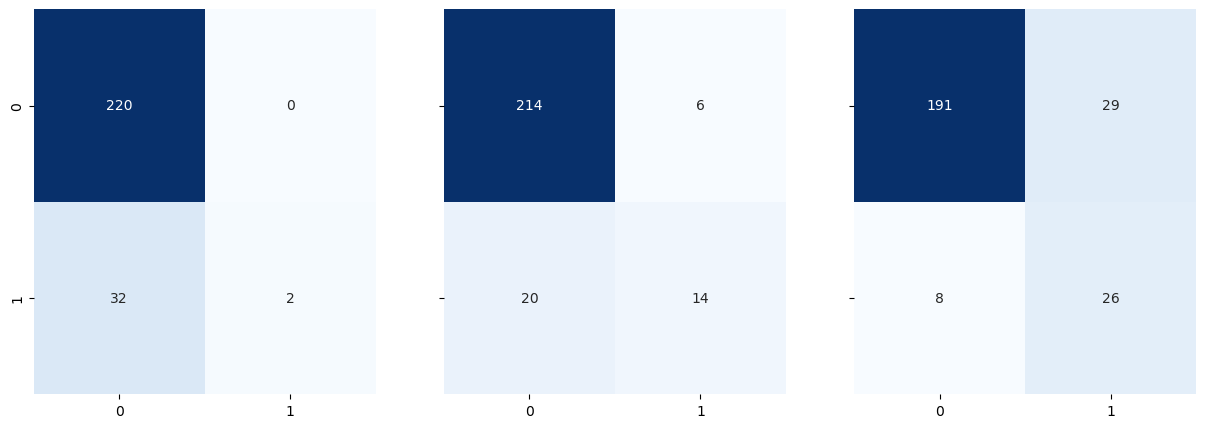

In [29]:
print("По умолчанию мерикa accuracy")
print("Тренировака: ", model_KNN.score(X_train,y_train), "   Тест : ", model_KNN.score(X_test,y_test))
print("Тренировака: ", model_LR.score(X_train,y_train), "   Тест : ", model_LR.score(X_test,y_test))
print("Тренировака: ", model_NB.score(X_train,y_train), "   Тест : ", model_NB.score(X_test,y_test))

matrix_1=confusion_matrix(y_test,y_KNN_pred)
matrix_2=confusion_matrix(y_test,y_LR_pred)
matrix_3=confusion_matrix(y_test,y_NB_pred)


fig,ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
ax = plt.subplot(1, 3, 1)
sns.heatmap(matrix_1,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 3, 2)
sns.heatmap(matrix_2,annot=True, fmt='g', cbar=None,cmap="Blues");
ax = plt.subplot(1, 3, 3)
sns.heatmap(matrix_3,annot=True, fmt='g', cbar=None,cmap="Blues");

*Для метода ближайших соседей - слишком большая разница между скорами для трейна и теста: модель переобучилась.*

*А высокий precision для соседей связан с тем, что модель редко определяет первый класс (всего 2 раза..)*

*Наивный байес слишком часто определяет результаты как первый класс (и часто ошибочно) - отсюда низкий precision.*

*И модель, аналогично, переобучена*



*Таким образом, воспользуемся моделью линейной регрессии. А чтобы повысить её параметры - оттюнингуем порог*

*Заметим, что 14 качественных вин определены верно - неплохо*

## Тюнинг порога

In [30]:
model_origin = model_LR
scoring = ["accuracy", 'precision', 'f1']
cv_scores = [
    "train_accuracy",
    "test_accuracy",
    "train_precision",
    "test_precision",
    'train_f1',
    'test_f1'
]

cv_results_model_origin = pd.DataFrame(
    cross_validate(
        model_origin,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
    )
)
cv_results_model_origin[cv_scores].agg(["mean", "std"]).T

,mean,std
train_accuracy,0.877465,0.006403
test_accuracy,0.877786,0.026182
train_precision,0.597004,0.043168
test_precision,0.601319,0.178446
train_f1,0.412890,0.047224
test_f1,0.431678,0.134224


In [43]:
model_tuned = TunedThresholdClassifierCV(estimator=model_origin, scoring='precision')
cv_results_model_tuned = pd.DataFrame(
    cross_validate(
        model_tuned,
        X_train,
        y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
    )
)
cv_results_model_tuned[cv_scores].agg(["mean", "std"]).T

,mean,std
train_accuracy,0.869578,0.005441
test_accuracy,0.854119,0.016575
train_precision,0.610563,0.046786
test_precision,0.357143,0.220800
train_f1,0.206950,0.165859
test_f1,0.168182,0.158541


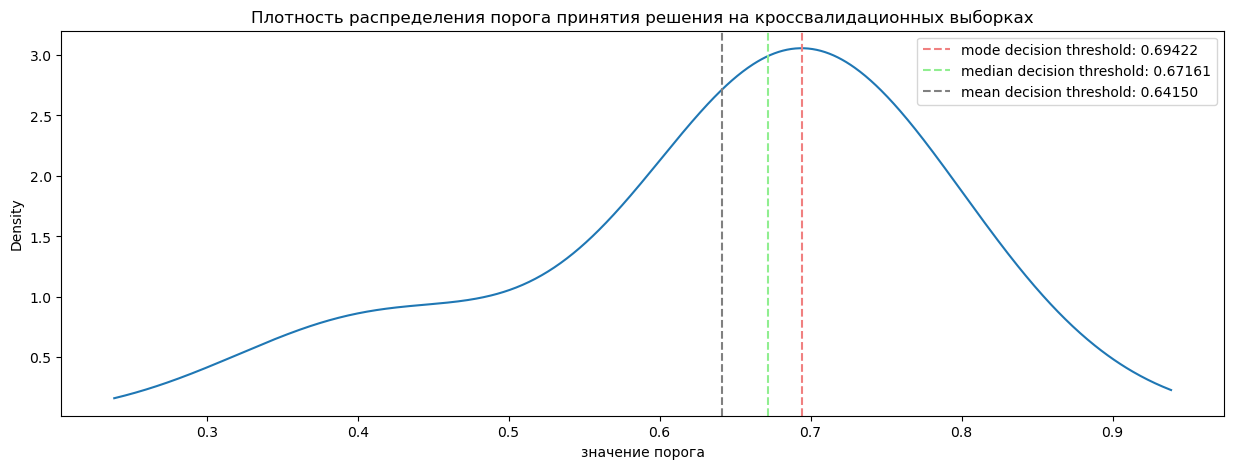

In [45]:
decision_threshold = pd.Series(
    [est.best_threshold_ for est in cv_results_model_tuned["estimator"]],
)

fig, ax = plt.subplots(figsize=(15,5))

ax = decision_threshold.plot.kde(bw_method=None)
line = ax.get_lines()
x_plt, y_plt = line[0].get_data()

ths = {
    'mode':   [x_plt[np.argmax(y_plt)],'lightcoral'],
    'median': [decision_threshold.median(), 'lightgreen'],
    'mean':   [decision_threshold.mean(),  'gray']
}

for key in ths.keys():
    ax.axvline(
        ths[key][0],
        color=ths[key][1],
        linestyle="--",
        label=f"{key} decision threshold: {ths[key][0]:.5f}",
    )

ax.set_xlabel("значение порога")
ax.legend(loc="upper right")
_ = ax.set_title(
    "Плотность распределения порога принятия решения на кроссвалидационных выборках"
)

In [46]:
ths_final = {
    'origin': 0.5,
    'mode':   x_plt[np.argmax(y_plt)],
    'median': decision_threshold.median(),
    'mean':   decision_threshold.mean(),
}
comparison =pd.DataFrame()
for key in ths_final:
    final_tune = FixedThresholdClassifier(model_origin, threshold=ths_final[key]).fit(X_train, y_train)
    comparison.loc[key,'train']= final_tune.score(X_train, y_train)
    comparison.loc[key,'test'] = final_tune.score(X_test, y_test)

comparison.sort_values(by='test')

,train,test
mode,0.867280,0.881890
median,0.867280,0.881890
mean,0.867280,0.881890
origin,0.876478,0.897638


origin
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       220
           1       0.70      0.41      0.52        34

    accuracy                           0.90       254
   macro avg       0.81      0.69      0.73       254
weighted avg       0.89      0.90      0.89       254

mode
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       220
           1       1.00      0.12      0.21        34

    accuracy                           0.88       254
   macro avg       0.94      0.56      0.57       254
weighted avg       0.90      0.88      0.84       254

median
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       220
           1       1.00      0.12      0.21        34

    accuracy                           0.88       254
   macro avg       0.94      0.56      0.57       254
weighted avg       0.90      0.88      0.84       254



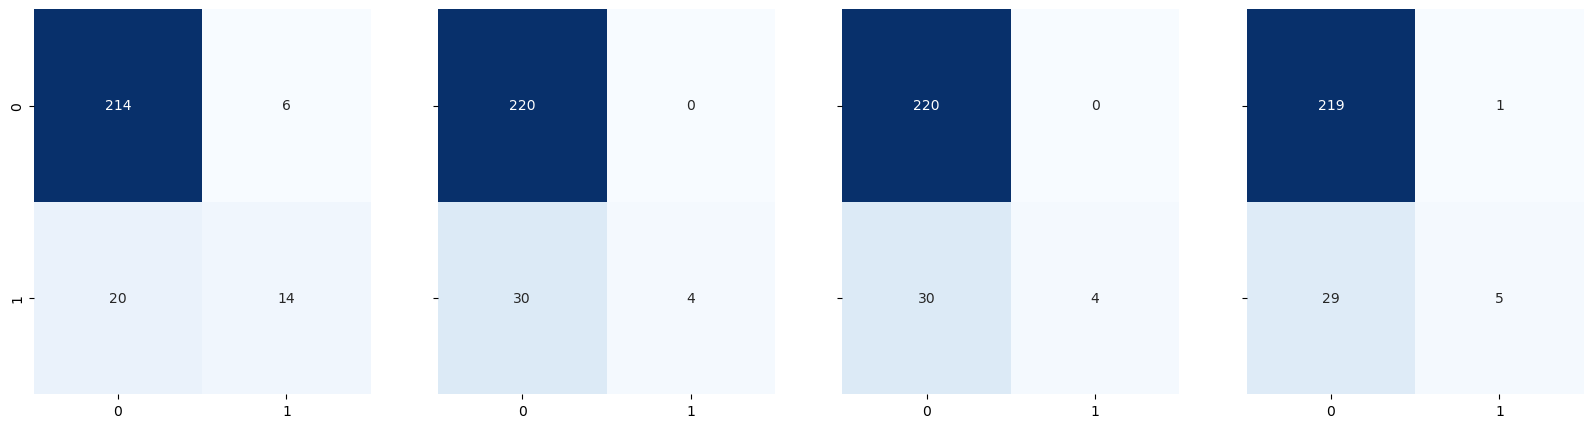

In [47]:
fig,ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,5))
count = 1
for i in ths_final.keys():
    final_tune = FixedThresholdClassifier(model_origin, threshold=ths_final[i]).fit(X_train, y_train)
    y_LR_pred = final_tune.predict(X_test)
    matrix=confusion_matrix(y_test,y_LR_pred)
    ax = plt.subplot(1, 4, count)
    sns.heatmap(matrix,annot=True, fmt='g', cbar=None,cmap="Blues");
    print(i)
    print(classification_report(y_test, y_LR_pred))
    count += 1

*precision 100% - да..но какой ценой (ценой recall) - не будем менять порог*

*если тюнить порог по f1, то, аналогично, резко снижается precision (а нам важно верно находить положительный класс)*